![Netflix](netflix.png)

<center> Image source: Netflix </center>

# **Problem Statment**

Classify consumers according to their appetite to subscribe to Netflix.

# **Dataset**

- `train.csv` - the training set. it consists of an id column, the customers features, and a target column: target.
- `test.csv` - the test set. it consists of everything in train.csv except target.
- `sample_submission.csv` - a sample submission file in the correct format target=1 means that the customer subscribes to Netflix

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pylab as plt
import seaborn as sns

from itertools import cycle

from sklearn import metrics, model_selection, preprocessing
from xgboost import XGBClassifier


from random import choice, choices
pd.set_option("display.max_columns", None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.style.use("ggplot")

import warnings
warnings.filterwarnings('ignore')

## **Dataset Loading**

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
ss_df = pd.read_csv("sample_submission.csv")

train_df.shape, test_df.shape, ss_df.shape

((70000, 509), (30000, 508), (30000, 2))

## Target Distribution

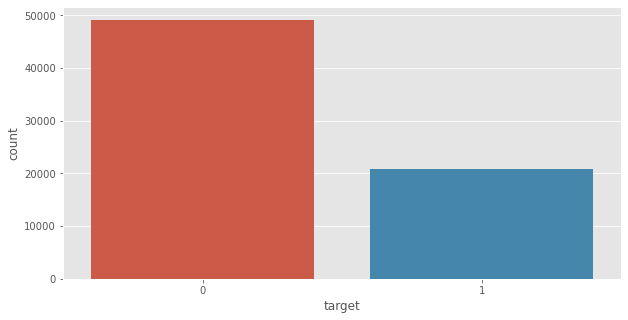

In [3]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(train_df.target)
plt.savefig('target_distribution.png')
plt.show()

## EDA

In [4]:
train_df.head()

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature

In [5]:
train_df.drop(columns=['id', 'target']).duplicated().sum()

1

In [6]:
train_df = train_df.drop_duplicates().reset_index(drop=True)

Only one duplicate is present in the dataset, we will drop that.

There are many columns which have lot of `NaN` features, we will drop these features.

In [7]:
## Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(train_df).head(30)

Your selected dataframe has 509 columns.
There are 73 columns that have missing values.


,Missing Values,% of Total Values
feature_193,70000,100.0
feature_196,70000,100.0
feature_197,70000,100.0
feature_198,70000,100.0
feature_83,68824,98.3
feature_75,49208,70.3
feature_76,49208,70.3
feature_195,44723,63.9
feature_5,44576,63.7
feature_8,44576,63.7


In [9]:
train_df.select_dtypes('object').head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_54,feature_55,feature_58,feature_97,feature_133,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_194,feature_195,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C60,C17795,C413,C3620,C0,C0,C0,C19,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C4,C41,C16133,C2,C16,C0,C1,C1,C2,C1483,C6,C0,C0,C20,C0,11/10/2017,11/10/2017,09/11/2017,NaN,11/10/2017,NaN,11/10/2017,NaN,NaN,NaN,C5,C0,C1,C1,C1,C0,C2,C140,C91,C0,C1,C1,C0,C0,C66,C63,C25,C10,C2,C1,C0,C0,C105,C86,C30,C13,C2,C1,C0,C2,C166,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C50,C14050,C413,C2819,C0,C0,C0,C23,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C21195,C2,C16,C0,C3,C1,C11,C1483,C8,C0,C0,C21,C0,25/03/2015,25/03/2015,NaN,NaN,02/04/2017,25/03/2015,25/03/2015,NaN,NaN,25/03/2015,C9,C0,C2,C2,C1,C14,C3,C193,C66,C0,C1,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C76,C23471,C413,C4794,C0,C0,C0,C22,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C11390,C2,C16,C0,C3,C1,C11,C1483,C4,C0,C0,C11,C0,27/01/2015,27/01/2015,13/05/2017,NaN,24/03/2016,27/01/2015,27/01/2015,NaN,NaN,27/01/2015,C9,C0,C2,C2,C1,C14,C3,C175,C66,C0,C1,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C58,C16929,C413,C3344,C0,C0,C0,C2,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C22367,C2,C16,C0,C3,C1,C1,C1483,C2,C0,C0,C5,C0,05/02/2014,01/04/2014,NaN,19/03/2014,01/04/2014,01/04/2014,01/04/2014,31/03/2014,31/03/2014,05/02/2014,C0,C0,C2,C2,C1,C0,C3,C193,C13,C0,C1,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C103,C84,C28,C13,C2,C1,C0,C0,C104,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C48,C13941,C413,C2753,C0,C0,C0,C3,C1,C1,C1,C1,C1,C1,C1,C0,C0,C0,C413,C0,C5,C1,C1652,C2,C16,C0,C0,C1,C11,C1483,C12,C0,C0,C11,C0,20/07/2009,10/09/2013,14/02/2017,NaN,10/09/2013,24/01/2016,10/09/2013,24/01/2016,10/09/2013,23/03/2011,C2,C0,C1,C1,C1,C0,C2,C60,C31,C0,C1,C1,C0,C0,C64,C61,C23,C10,C2,C1,C0,C0,C86,C69,C24,C11,C2,C1,C0,C0,C114,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1


## Drop features:
 - Features with more than 10% null values
 - Features with single categorical features
 - Features with single values features

In [10]:
# Drop features with more than 10% null values
drop_columns = [
    'feature_193', 'feature_196', 'feature_197', 'feature_198',
    'feature_83', 'feature_76', 'feature_75', 'feature_11', 'feature_5', 'feature_8',
    'feature_12', 'feature_9', 'feature_6', 'feature_10', 'feature_13', 'feature_7', 
    'feature_86', 'feature_85', 'feature_84','feature_172', 'feature_255', 'feature_153', 
]
# Single catgorical features
drop_columns.extend([
    'feature_190', 'feature_55', 'feature_187', 'feature_188',
    'feature_249', 'feature_248',
])
# Single value features
drop_columns.extend([
       'feature_461', 'feature_474', 'feature_472', 'feature_409',
       'feature_469', 'feature_467', 'feature_411', 'feature_465',
       'feature_312', 'feature_463', 'feature_313', 'feature_375',
       'feature_427', 'feature_412', 'feature_413', 'feature_455',
       'feature_453', 'feature_419', 'feature_451', 'feature_100',
       'feature_449', 'feature_421', 'feature_445', 'feature_433',
       'feature_432', 'feature_459', 'feature_476', 'feature_405',
       'feature_425', 'feature_498', 'feature_227', 'feature_228',
       'feature_149', 'feature_495', 'feature_385', 'feature_493',
       'feature_478', 'feature_491', 'feature_389', 'feature_489',
       'feature_252', 'feature_487', 'feature_502', 'feature_505',
       'feature_484', 'feature_395', 'feature_482', 'feature_377',
       'feature_358', 'feature_480', 'feature_397', 'feature_357',
       'feature_500'
])

train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

train_df.shape, test_df.shape

((70000, 428), (30000, 427))

In [11]:
#features info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 428 entries, id to feature_506
dtypes: float64(120), int64(222), object(86)
memory usage: 228.6+ MB


We have `float`, `int`, `object` type featues in train data.
Now we have 428 columns out of 509 columns in the training set.

## Categorical Columns**

In [12]:
train_df.select_dtypes('object').head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_54,feature_58,feature_97,feature_133,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_185,feature_186,feature_189,feature_191,feature_192,feature_194,feature_195,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_246,feature_247,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C60,C17795,C413,C3620,C0,C0,C0,C19,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C4,C41,C16133,C2,C16,C0,C1,C1,C2,C1483,C6,C20,11/10/2017,11/10/2017,09/11/2017,NaN,11/10/2017,NaN,11/10/2017,NaN,NaN,NaN,C5,C0,C1,C1,C1,C0,C2,C140,C91,C1,C0,C0,C66,C63,C25,C10,C2,C1,C0,C0,C105,C86,C30,C13,C2,C1,C0,C2,C166,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C50,C14050,C413,C2819,C0,C0,C0,C23,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C7,C41,C21195,C2,C16,C0,C3,C1,C11,C1483,C8,C21,25/03/2015,25/03/2015,NaN,NaN,02/04/2017,25/03/2015,25/03/2015,NaN,NaN,25/03/2015,C9,C0,C2,C2,C1,C14,C3,C193,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C76,C23471,C413,C4794,C0,C0,C0,C22,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C7,C41,C11390,C2,C16,C0,C3,C1,C11,C1483,C4,C11,27/01/2015,27/01/2015,13/05/2017,NaN,24/03/2016,27/01/2015,27/01/2015,NaN,NaN,27/01/2015,C9,C0,C2,C2,C1,C14,C3,C175,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C58,C16929,C413,C3344,C0,C0,C0,C2,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C7,C41,C22367,C2,C16,C0,C3,C1,C1,C1483,C2,C5,05/02/2014,01/04/2014,NaN,19/03/2014,01/04/2014,01/04/2014,01/04/2014,31/03/2014,31/03/2014,05/02/2014,C0,C0,C2,C2,C1,C0,C3,C193,C13,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C103,C84,C28,C13,C2,C1,C0,C0,C104,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C48,C13941,C413,C2753,C0,C0,C0,C3,C1,C1,C1,C1,C1,C1,C1,C0,C0,C0,C413,C5,C1,C1652,C2,C16,C0,C0,C1,C11,C1483,C12,C11,20/07/2009,10/09/2013,14/02/2017,NaN,10/09/2013,24/01/2016,10/09/2013,24/01/2016,10/09/2013,23/03/2011,C2,C0,C1,C1,C1,C0,C2,C60,C31,C1,C0,C0,C64,C61,C23,C10,C2,C1,C0,C0,C86,C69,C24,C11,C2,C1,C0,C0,C114,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1


- We can observe that those are catgorical features encoded with some labels
- We can also observe that some data features, we can drop those as of now

In [13]:
# Droping Date features
date_columns = ['feature_191', 'feature_192', 'feature_194', 'feature_195', 'feature_199', 'feature_200', 'feature_201', 'feature_202', 'feature_203', 'feature_204']
display(train_df[date_columns].head())

train_df = train_df.drop(columns=date_columns)
test_df = test_df.drop(columns=date_columns)

train_df.shape, test_df.shape

,feature_191,feature_192,feature_194,feature_195,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204
0,11/10/2017,11/10/2017,09/11/2017,NaN,11/10/2017,NaN,11/10/2017,NaN,NaN,NaN
1,25/03/2015,25/03/2015,NaN,NaN,02/04/2017,25/03/2015,25/03/2015,NaN,NaN,25/03/2015
2,27/01/2015,27/01/2015,13/05/2017,NaN,24/03/2016,27/01/2015,27/01/2015,NaN,NaN,27/01/2015
3,05/02/2014,01/04/2014,NaN,19/03/2014,01/04/2014,01/04/2014,01/04/2014,31/03/2014,31/03/2014,05/02/2014
4,20/07/2009,10/09/2013,14/02/2017,NaN,10/09/2013,24/01/2016,10/09/2013,24/01/2016,10/09/2013,23/03/2011


((70000, 418), (30000, 417))

- we can see that some featues have only single catgorie, so we can drop those featues
- Some freatures more then 100 unique catgories, we can drop those also

In [15]:
cat_columns = [col for col in train_df.select_dtypes('object').columns]
train_df[cat_columns].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_54,feature_58,feature_97,feature_133,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_185,feature_186,feature_189,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_246,feature_247,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C60,C17795,C413,C3620,C0,C0,C0,C19,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C4,C41,C16133,C2,C16,C0,C1,C1,C2,C1483,C6,C20,C5,C0,C1,C1,C1,C0,C2,C140,C91,C1,C0,C0,C66,C63,C25,C10,C2,C1,C0,C0,C105,C86,C30,C13,C2,C1,C0,C2,C166,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C50,C14050,C413,C2819,C0,C0,C0,C23,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C7,C41,C21195,C2,C16,C0,C3,C1,C11,C1483,C8,C21,C9,C0,C2,C2,C1,C14,C3,C193,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C76,C23471,C413,C4794,C0,C0,C0,C22,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C7,C41,C11390,C2,C16,C0,C3,C1,C11,C1483,C4,C11,C9,C0,C2,C2,C1,C14,C3,C175,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C58,C16929,C413,C3344,C0,C0,C0,C2,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C7,C41,C22367,C2,C16,C0,C3,C1,C1,C1483,C2,C5,C0,C0,C2,C2,C1,C0,C3,C193,C13,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C103,C84,C28,C13,C2,C1,C0,C0,C104,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C48,C13941,C413,C2753,C0,C0,C0,C3,C1,C1,C1,C1,C1,C1,C1,C0,C0,C0,C413,C5,C1,C1652,C2,C16,C0,C0,C1,C11,C1483,C12,C11,C2,C0,C1,C1,C1,C0,C2,C60,C31,C1,C0,C0,C64,C61,C23,C10,C2,C1,C0,C0,C86,C69,C24,C11,C2,C1,C0,C0,C114,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1


## Numerical Columns

In [16]:
train_df.select_dtypes(['int', 'float']).head()

,feature_14,feature_15,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_56,feature_57,feature_59,feature_60,feature_61,feature_63,feature_67,feature_68,feature_81,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_128,feature_129,feature_130,feature_131,feature_132,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_210,feature_212,feature_214,feature_216,feature_218,feature_220,feature_222,feature_224,feature_226,feature_230,feature_232,feature_234,feature_236,feature_238,feature_254,feature_256,feature_257,feature_258,feature_259,feature_260,feature_340,feature_342,feature_344,feature_346,feature_348,feature_350,feature_352,feature_354,feature_356,feature_360,feature_362,feature_364,feature_366,feature_368,feature_370,feature_373,feature_379,feature_381,feature_383,feature_387,feature_391,feature_393,feature_399,feature_401,feature_403,feature_407,feature_415,feature_417,feature_423,feature_429,feature_431,feature_435,feature_437,feature_439,feature_441,feature_443,feature_447,feature_457
0,0.0,0.000,-17.527805,-77.832935,0.003995,15989.268352,-17.52451,1086.899174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.250000,0.0,0.0,3.0,0.00,0.00,0.0,0.000000,0.805000,110267119.0,1.258826e+08,102447817.5,4220083.0,5.377666e+06,4291673.0,114487202.0,131260232.0,106739490.5,1.73,1.730000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,2678327.0,2.636656e+06,1.989782e+06,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,22.0,26.0,26.000000,78.0,22.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000,0.000000,0.000000,-18.899991,5.169404,0.00000,0.000000,0.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,34.0,0.0,0.0,0.000000,0.0,1.0,0.0,2.666667,2.0,2.0,3.0,3.57,3.57,0.0,1.190000,1.150000,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,148459792.0,1.772011e+08,1.728461e+08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,200.0,200.0,206.666667,620.0,200.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000,0.000000,0.000000,7.167159,-33.030314,0.00000,0.000000,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,36.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,115326888.0,1.078111e+08,1.343980e+08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,180.0,168.0,169.333333,508.0,180.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000,0.000000,0.000000,-4.065911,126.551718,0.00000,0.000000,0.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,48.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.500000,0.0,1.0,6.0,0.00,0.00,0.0,1.076667,2.723333,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,194802356.0,2.084141e+08,1.502041e+08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,201.0,288.0,249.333333,748.0,201.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000

- We can observe that nan values also present in numarical columns

In [17]:
target_column = 'target'
drop_columns = ['id', target_column]

num_columns = [col for col in train_df.select_dtypes(['int', 'float']).columns if col not in drop_columns]
train_df[num_columns].head()

,feature_14,feature_15,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_56,feature_57,feature_59,feature_60,feature_61,feature_63,feature_67,feature_68,feature_81,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_128,feature_129,feature_130,feature_131,feature_132,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_210,feature_212,feature_214,feature_216,feature_218,feature_220,feature_222,feature_224,feature_226,feature_230,feature_232,feature_234,feature_236,feature_238,feature_254,feature_256,feature_257,feature_258,feature_259,feature_260,feature_340,feature_342,feature_344,feature_346,feature_348,feature_350,feature_352,feature_354,feature_356,feature_360,feature_362,feature_364,feature_366,feature_368,feature_370,feature_373,feature_379,feature_381,feature_383,feature_387,feature_391,feature_393,feature_399,feature_401,feature_403,feature_407,feature_415,feature_417,feature_423,feature_429,feature_431,feature_435,feature_437,feature_439,feature_441,feature_443,feature_447,feature_457
0,0.0,0.000,-17.527805,-77.832935,0.003995,15989.268352,-17.52451,1086.899174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.250000,0.0,0.0,3.0,0.00,0.00,0.0,0.000000,0.805000,110267119.0,1.258826e+08,102447817.5,4220083.0,5.377666e+06,4291673.0,114487202.0,131260232.0,106739490.5,1.73,1.730000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,2678327.0,2.636656e+06,1.989782e+06,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,22.0,26.0,26.000000,78.0,22.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000,0.000000,0.000000,-18.899991,5.169404,0.00000,0.000000,0.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,34.0,0.0,0.0,0.000000,0.0,1.0,0.0,2.666667,2.0,2.0,3.0,3.57,3.57,0.0,1.190000,1.150000,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,148459792.0,1.772011e+08,1.728461e+08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,200.0,200.0,206.666667,620.0,200.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000,0.000000,0.000000,7.167159,-33.030314,0.00000,0.000000,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,36.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,115326888.0,1.078111e+08,1.343980e+08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,180.0,168.0,169.333333,508.0,180.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000,0.000000,0.000000,-4.065911,126.551718,0.00000,0.000000,0.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,48.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.500000,0.0,1.0,6.0,0.00,0.00,0.0,1.076667,2.723333,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,194802356.0,2.084141e+08,1.502041e+08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,201.0,288.0,249.333333,748.0,201.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000

In [ ]:
# Number of unique values 
train_df[num_columns].nunique().sort_values().to_frame().T

- We can found some featues have unique values, we can drop those features

### Feature Distribution**

- Lets see top 9 more unique features distributions

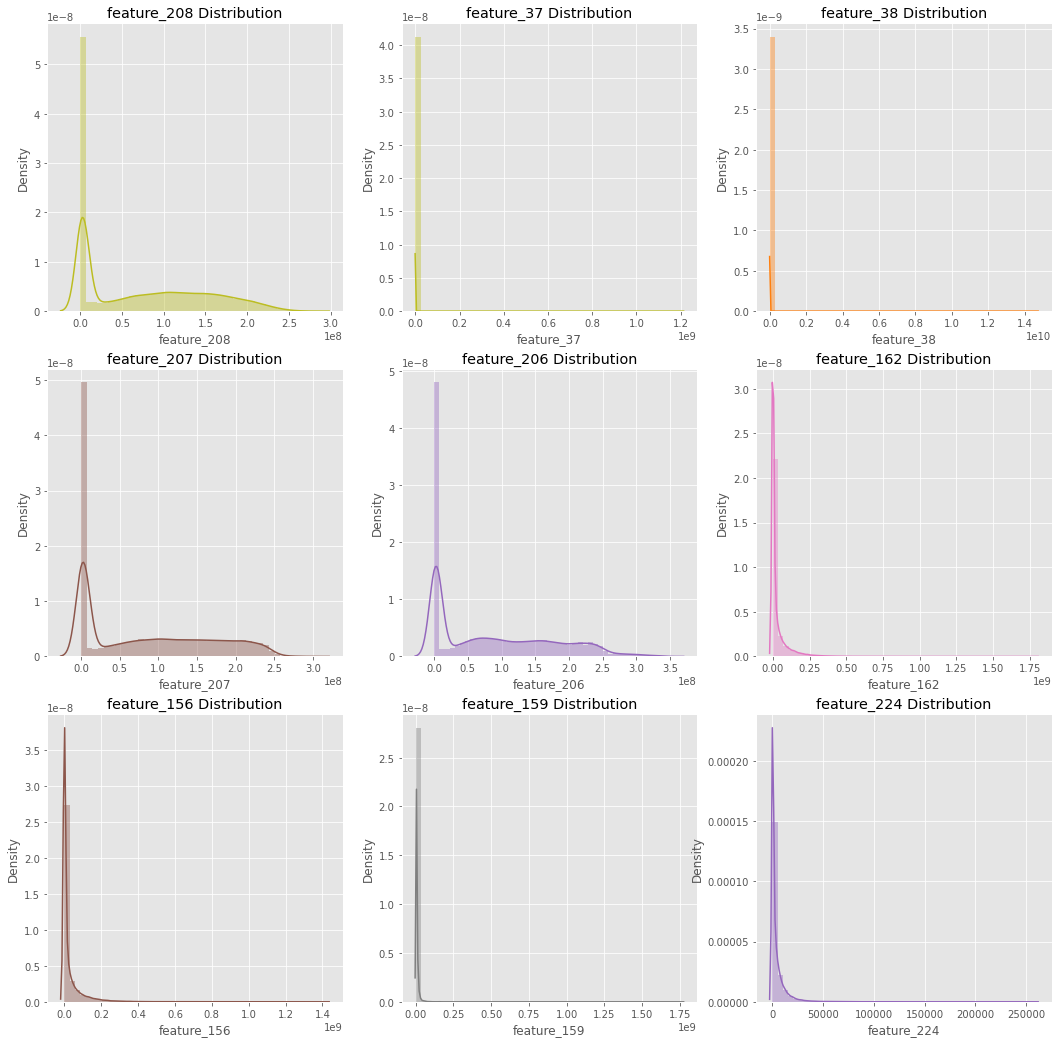

In [18]:
num_columns = [col for col in train_df.select_dtypes(['int', 'float']).columns if col not in drop_columns]

top9_columns =  train_df[num_columns].nunique().sort_values(ascending=False).index.values[:9]

fig, ax = plt.subplots(3,3, figsize=(18, 18))
for i, col in enumerate(top9_columns):
    sns.distplot(train_df[col], color = choice(color_pal), ax=ax[math.floor(i/3),i%3]).set_title(f'{col} Distribution')
fig.savefig('top_feature_distribution.png')
fig.show()

### Correlation Heatmap

Lets analyze the correlation of first nine features

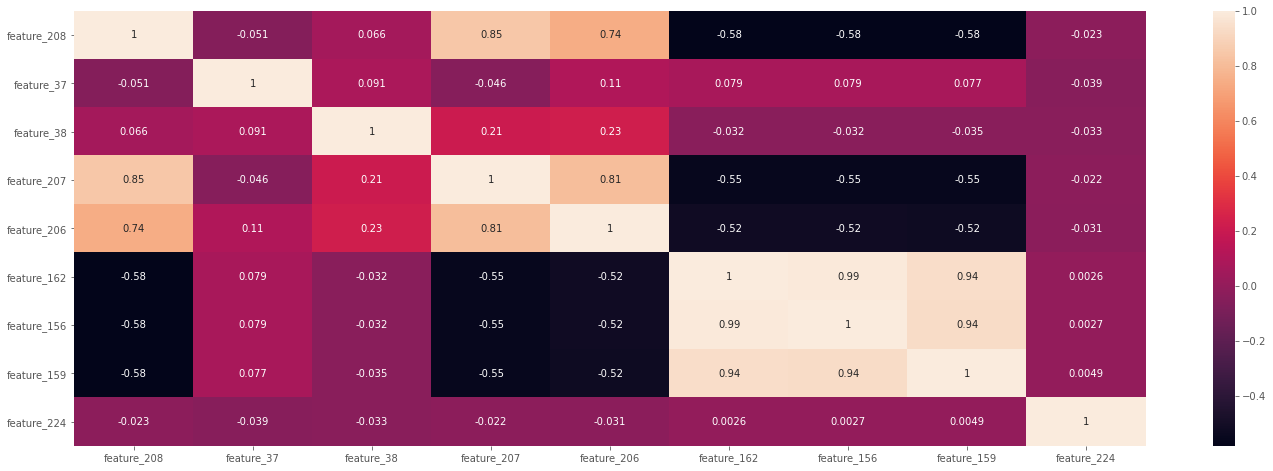

In [19]:
#Get Correlation between different variables
corr = train_df[top9_columns].corr(method='kendall')
plt.figure(figsize=(24,8))
sns.heatmap(corr, annot=True)
plt.savefig('correlation.png')

- We can observe that some featues are more correlated each other

### Correlation of Target and Features


In [20]:
num_columns = [col for col in train_df.select_dtypes(['int', 'float']).columns if col not in drop_columns]

corr_df = train_df[['target'] + num_columns].corr()

,target,feature_81,feature_254,feature_169,feature_224,feature_354,feature_132,feature_168,feature_67,feature_131,feature_128,feature_381,feature_174,feature_129,feature_415,feature_348,feature_173,feature_208,feature_206,feature_91,feature_93,feature_92,feature_87,feature_383,feature_403,feature_207,feature_130,feature_435,feature_391,feature_68,feature_218,feature_437,feature_352,feature_167,feature_366,feature_346,feature_441,feature_236,feature_171,feature_170,feature_370,feature_256,feature_260,feature_258,feature_387,feature_429,feature_182,feature_177,feature_60,feature_15,feature_257,feature_156,feature_162,feature_457,feature_259,feature_166,feature_216,feature_14,feature_356,feature_161,feature_155,feature_368,feature_340,feature_160,feature_210,feature_154,feature_181,feature_96,feature_220,feature_212,feature_342,feature_158,feature_226,feature_94,feature_157,feature_222,feature_439,feature_90,feature_95,feature_417,feature_399,feature_360,feature_176,feature_401,feature_184,feature_159,feature_61,feature_88,feature_407,feature_179,feature_39,feature_35,feature_379,feature_230,feature_36,feature_443,feature_350,feature_373,feature_40,feature_344,feature_56,feature_57,feature_89,feature_38,feature_175,feature_447,feature_37,feature_362,feature_178,feature_238,feature_393,feature_180,feature_214,feature_431,feature_183,feature_423,feature_234,feature_232,feature_63,feature_364,feature_59
target,1.0,0.157207,0.105075,0.095116,0.087431,0.086687,0.08244,0.076369,0.064179,0.063773,0.061416,0.059072,0.05618,0.054355,0.054047,0.053391,0.052283,0.049292,0.048553,0.047255,0.046884,0.045483,0.045046,0.042789,0.04145,0.041247,0.040659,0.040354,0.038611,0.037448,0.037276,0.036241,0.035636,0.034633,0.034358,0.03096,0.030206,0.029795,0.028674,0.025737,0.023614,0.023253,0.023229,0.022014,0.020642,0.020086,0.019236,0.018797,0.018746,0.017861,0.017718,0.017544,0.017376,0.017239,0.01676,0.016659,0.016237,0.015659,0.01486,0.014826,0.014522,0.014077,0.01367,0.013574,0.013393,0.013155,0.012779,0.012693,0.01269,0.012661,0.012599,0.012392,0.011974,0.011943,0.011675,0.01158,0.011109,0.010838,0.010769,0.010664,0.010176,0.009451,0.009221,0.008996,0.008863,0.008146,0.007136,0.007111,0.007055,0.006717,0.006545,0.006519,0.006497,0.006381,0.005992,0.00496,0.004674,0.004637,0.004634,0.004297,0.004024,0.004007,0.003913,0.003641,0.003484,0.003371,0.003122,0.003102,0.002955,0.002809,0.002492,0.002418,0.001998,0.001766,0.001253,0.001234,0.001159,0.000824,0.000672,0.000616,0.000134


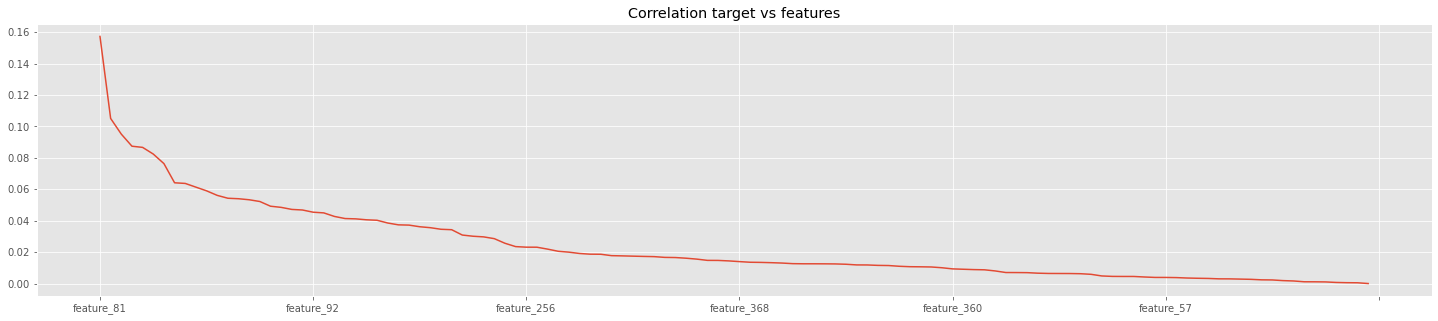

In [21]:
# Correlation with target
display(corr_df['target'].abs().sort_values(ascending=False).to_frame().T)

plt.figure(figsize=(25,5))
corr_df['target'].abs().sort_values(ascending=False).iloc[1:].plot()
plt.title("Correlation target vs features")
plt.show()

- We can observe that `feature_307`, `feature_297` are more correlated with target

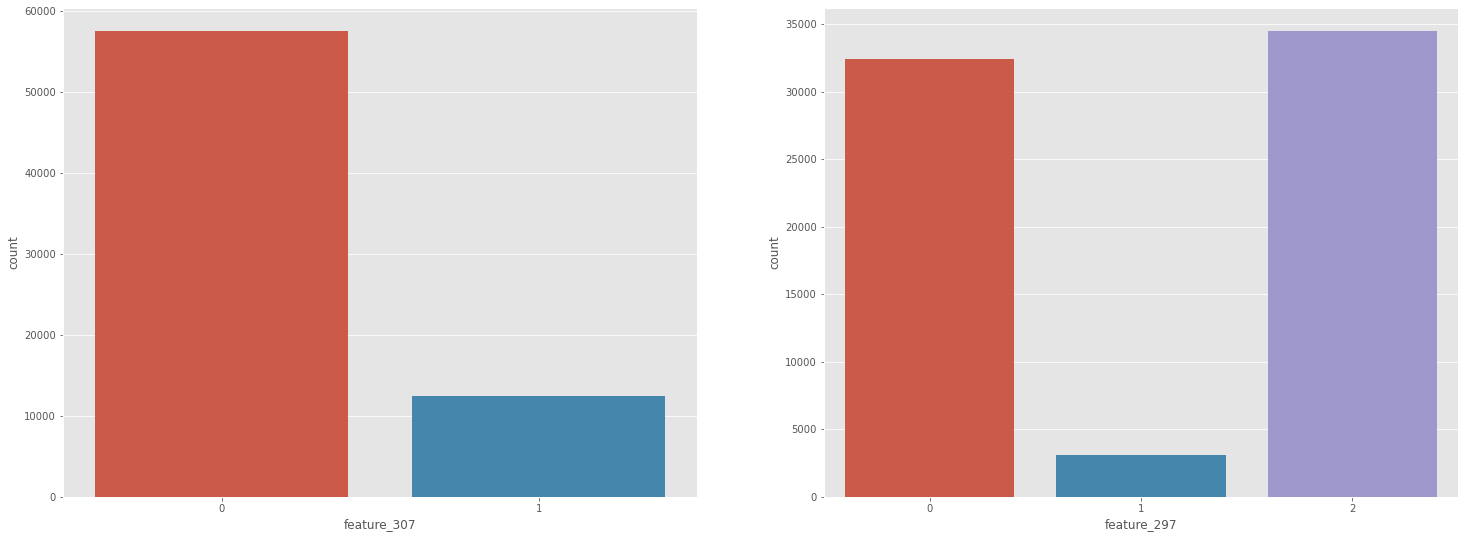

In [22]:
plt.figure(figsize=(25, 9))

# feature_307
plt.subplot(121)
sns.countplot(train_df['feature_307'])

# feature_297
plt.subplot(122)
sns.countplot(train_df['feature_297'])
plt.show()

- `feature_307` is binary feature, those binary values more correlated with targets

In [23]:
# feature_307 feature auc with target 
metrics.roc_auc_score(train_df['target'], train_df['feature_307'])

0.6401047553543626

- with out any model we can get `0.64` AUC

## Preprocessing

In [24]:
## label encoding those categorical columns
def label_encoding(train_df, test_df, columns):
    for col in columns:
        le = preprocessing.LabelEncoder()
        values = train_df[col].append(test_df[col])
        le.fit(values)
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
    return train_df, test_df

train_df, test_df = label_encoding(train_df, test_df, cat_columns)
train_df[cat_columns].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_54,feature_58,feature_97,feature_133,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_185,feature_186,feature_189,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_246,feature_247,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,0,0,1,5,3,0,61,5737,263,2808,0,0,0,11,0,0,0,0,0,0,0,0,0,0,248,3,28,2732,2,7,0,1,1,4,118,10,12,5,0,1,1,1,0,2,34,82,1,0,0,59,56,16,2,2,1,0,0,7,98,21,5,2,1,0,2,56,28,34,14,2,6,5,0,0,0,0
1,0,0,3,5,1,2,50,3082,263,1951,0,0,0,16,0,0,0,0,0,0,0,0,0,0,248,6,28,4915,2,7,0,3,1,3,118,12,13,9,0,2,2,1,6,3,79,60,1,0,0,74,67,20,5,5,2,1,0,27,6,26,9,6,3,2,0,31,7,26,9,7,3,2,0,0,0,0
2,0,0,3,5,4,1,78,9673,263,4066,0,0,0,15,0,0,0,0,0,0,0,0,0,0,248,6,28,660,2,7,0,3,1,3,118,8,3,9,0,2,2,1,6,3,63,60,1,0,0,74,67,20,5,5,2,1,0,27,6,26,9,6,3,2,0,31,7,26,9,7,3,2,0,0,0,0
3,0,0,1,5,1,0,58,5079,263,2516,0,0,0,12,0,0,0,0,0,0,0,0,0,0,248,6,28,5378,2,7,0,3,1,1,118,6,16,0,0,2,2,1,0,3,79,12,1,0,0,71,66,19,4,3,1,0,0,5,96,18,5,2,1,0,0,7,101,19,5,3,1,0,0,0,0,0
4,0,0,3,3,3,2,47,3016,263,1881,0,0,0,19,1,1,1,1,1,1,1,0,0,0,248,4,0,2915,2,7,0,0,1,3,118,4,3,2,0,1,1,1,0,2,117,29,1,0,0,57,54,14,2,2,1,0,0,123,79,15,3,2,1,0,0,18,112,16,3,3,1,0,0,0,0,1


## Modeling

In [25]:
target_col = 'target'
drop_cols = [target_col, 'id']
train_cols = [col for col in train_df.columns if col not in drop_cols]

## Hyerparameter Tunning

In [26]:
missing_values_table(train_df)

Your selected dataframe has 418 columns.
There are 42 columns that have missing values.


,Missing Values,% of Total Values
feature_206,1937,2.8
feature_257,1937,2.8
feature_157,1937,2.8
feature_160,1937,2.8
feature_154,1937,2.8
feature_207,1601,2.3
feature_161,1601,2.3
feature_258,1601,2.3
feature_158,1601,2.3
feature_155,1601,2.3


# Model Training

## XGBoost

In [27]:
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
test_predictions = []

oof_predictions_proba = np.zeros(len(train_df))

X_test = test_df[train_cols]

for idx, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df[target_col])):

    print("="*125)
    print("FOLD : ", idx)
    print("_"*125)
    
    X_train = train_df.iloc[train_idx][train_cols]
    y_train = train_df.iloc[train_idx][target_col]

    X_valid = train_df.iloc[valid_idx][train_cols]
    y_valid = train_df.iloc[valid_idx][target_col]

    
    XGB_params = {
   'n_estimators': 14140,
    'learning_rate': 0.0111538499996725174,
    'max_depth': 4,
    'reg_alpha': 2.9735993984217104,
    'reg_lambda': 2.214625977393439,
    'scale_pos_weight': 0.9,
    'subsample': 0.7768428006197691,
    'gamma': 0.5
    }
    

    model = XGBClassifier(**XGB_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
            early_stopping_rounds=200, 
            eval_metric='auc',
            verbose=100)

    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    predictions = model.predict_proba(X_test)[:, 1]

    test_predictions.append(predictions)
    oof_predictions_proba[valid_idx] = y_valid_pred

score = metrics.roc_auc_score(train_df[target_col], oof_predictions_proba)
test_predictions = np.mean(test_predictions, axis=0)
xgb_test_predictions = test_predictions

print("OOF MEAN AUC :", score)

FOLD :  0
_____________________________________________________________________________________________________________________________
[0]	validation_0-auc:0.73777
[100]	validation_0-auc:0.75603
[200]	validation_0-auc:0.76320
[300]	validation_0-auc:0.76905
[400]	validation_0-auc:0.77230
[500]	validation_0-auc:0.77418
[600]	validation_0-auc:0.77571
[700]	validation_0-auc:0.77675
[800]	validation_0-auc:0.77746
[900]	validation_0-auc:0.77803
[1000]	validation_0-auc:0.77842
[1100]	validation_0-auc:0.77879
[1200]	validation_0-auc:0.77900
[1300]	validation_0-auc:0.77917
[1400]	validation_0-auc:0.77929
[1500]	validation_0-auc:0.77939
[1600]	validation_0-auc:0.77948
[1700]	validation_0-auc:0.77951
[1800]	validation_0-auc:0.77953
[1900]	validation_0-auc:0.77955
[2000]	validation_0-auc:0.77952
[2063]	validation_0-auc:0.77956
FOLD :  1
_____________________________________________________________________________________________________________________________
[0]	validation_0-auc:0.74280
[100]	v

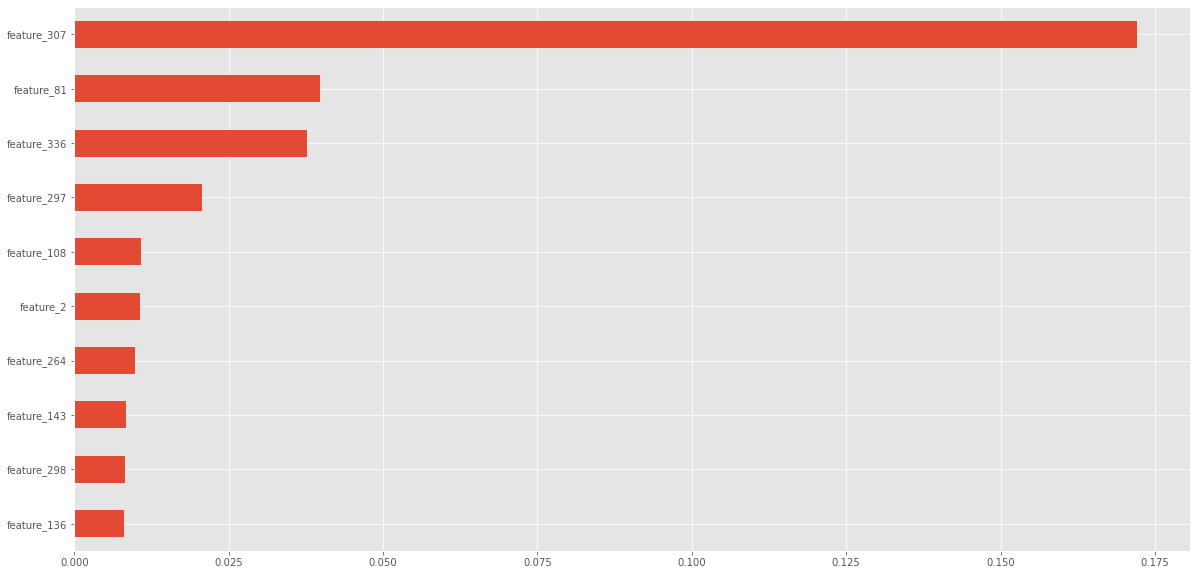

In [31]:
# feature importance
fig, ax = plt.subplots(figsize=(20, 10))
fi = pd.Series(index = train_cols, data = model.feature_importances_)
fi.sort_values(ascending=False)[0:10][::-1].plot(kind = 'barh')
plt.savefig('feature_importance.png')
plt.show()

In [32]:
## Submission
ss_df['target'] = xgb_test_predictions
ss_df.head()

,id,target
0,5,0.362409
1,7,0.296590
2,9,0.291430
3,11,0.113601
4,14,0.246537


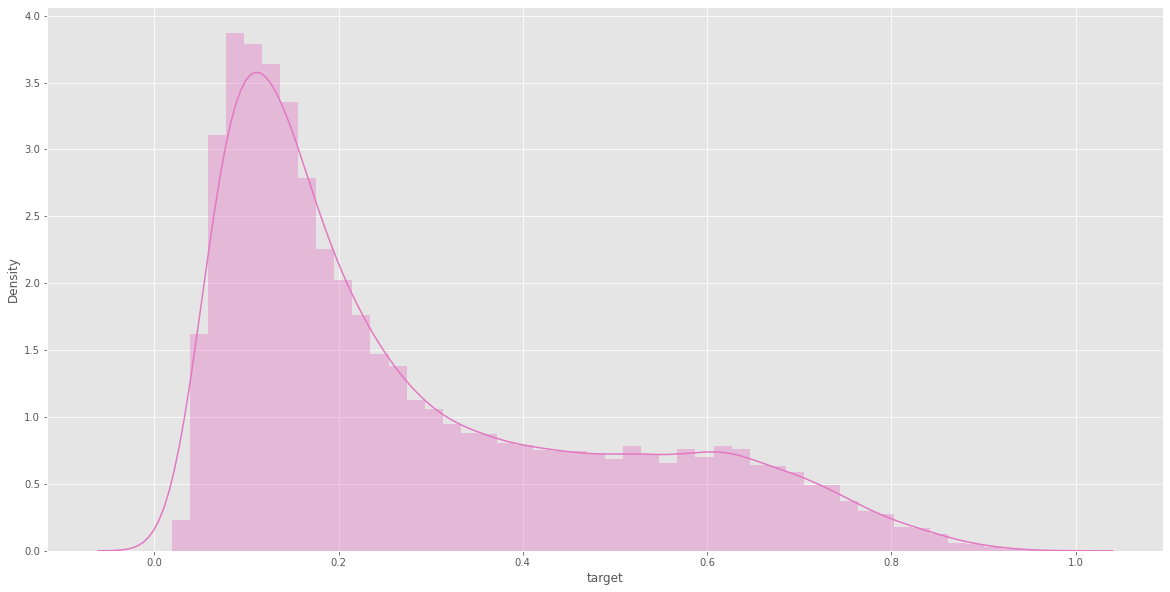

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(ss_df['target'], color=choice(color_pal), ax=ax)
plt.show()

## End of the Notebook